## Initialization

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Grid size
NX = 20
NY = 30

omega = 1

weights = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
#weights = np.array([5/9, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18])
c = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1]])

######
# Initialise arrays

scenario = 0;

if(scenario == 0):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    dfield[NX//4*3, NY//2] *= 2

if(scenario == 1):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    dfield[:, :] = 1 + 0.5 * np.sin(2*np.pi*np.arange(0,NY)/NX)

if(scenario == 2):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

    vfield[0, :, :] = 0.01 * np.sin(2*np.pi*np.arange(0,NY)/NX)

if(scenario == 3):
    dfield = np.ones((NX, NY))
    vfield = np.zeros((2, NX, NY))

ffield = np.einsum("i,jk -> ijk", weights, np.ones((NX, NY)))  # Format: (channel, x, y)
######

## Show density before simulation

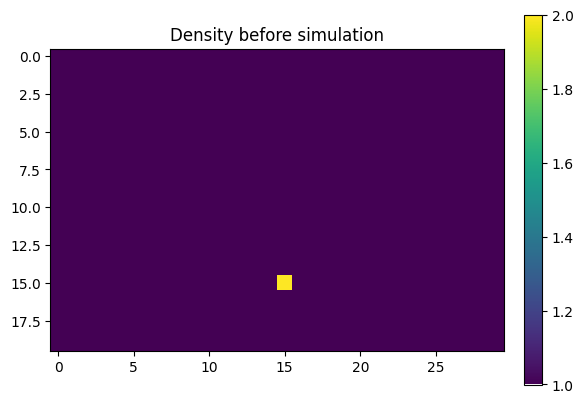

In [278]:
fig, ax = plt.subplots()
im = ax.imshow(dfield)
plt.title("Density before simulation")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

In [279]:
def calc_equi(dfield, vfield):
    # Caluculate the equilibrium distribution function
    f_equi = np.zeros_like(ffield)
    v_abs = np.einsum("ijk -> jk", vfield)  # Maybe negative but will be squared anyway
    for channel in range(9):
        scal = np.einsum("i, ijk -> jk", c[channel], vfield)
        sum = np.ones_like(scal) + 3 * scal + 9/2 * scal * scal - 3/2 * v_abs * v_abs
        f_equi[channel, :, :] = weights[channel] * dfield * sum
    return f_equi

def streaming(dfield, ffield, boundary = "periodic"):
    f_equi = calc_equi(dfield, vfield)

    ffield += omega * (f_equi - ffield)

    for channel in range(9):
        ffield[channel] = np.roll(ffield[channel], shift=c[channel], axis=(0,1))
    ffield[3, -2, :] = ffield[1, -1, :]
    ffield[:, -1, :] = ffield[:, 0, :]


    return ffield

In [280]:
def recalculate(ffield, dfield, vfield):

    dfield = np.einsum("ijk -> jk", ffield)  # density field
    vfield_noscale = np.einsum("ijk, il -> ljk", ffield, c)  # velocity field
    vfield = np.einsum("ijk, jk -> ijk", vfield_noscale, np.reciprocal(dfield))  # divide by rho to get averange velocity

    return ffield, dfield, vfield

dfield_init = dfield

Simulating: 100%|██████████| 10/10 [00:00<00:00, 1470.04it/s]


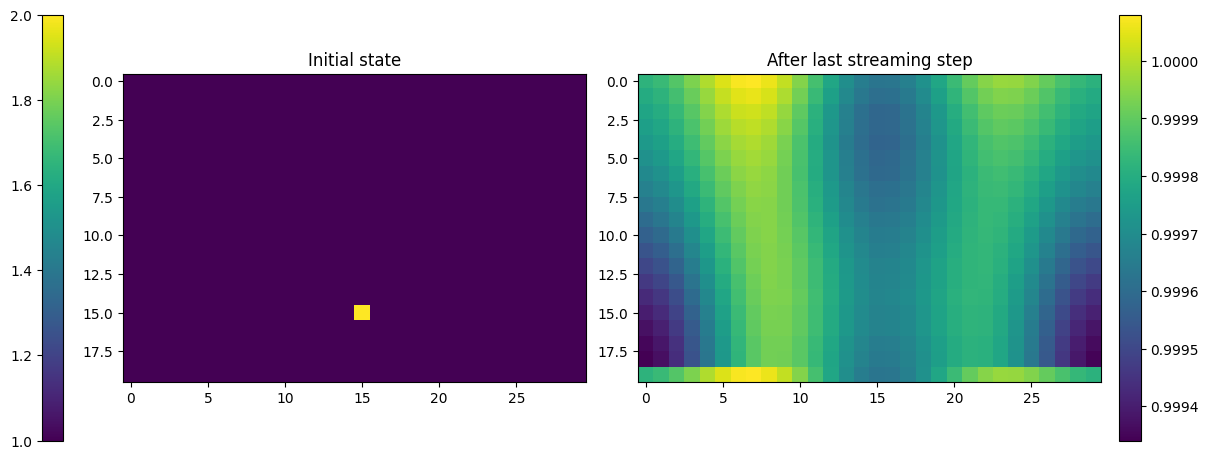

[[-1.82144613e-04 -1.59277012e-04 -1.18243596e-04 -6.47711123e-05
  -8.60775713e-06  4.04557083e-05  7.23236510e-05  7.99757441e-05
   5.97005905e-05  1.24040991e-05 -5.64179767e-05 -1.38080666e-04
  -2.21007929e-04 -2.94206258e-04 -3.47060603e-04 -3.73374366e-04
  -3.69778332e-04 -3.38883697e-04 -2.86088347e-04 -2.21171064e-04
  -1.54257053e-04 -9.61217947e-05 -5.47721594e-05 -3.52831387e-05
  -3.84154773e-05 -6.06577316e-05 -9.54624289e-05 -1.33464725e-04
  -1.65748067e-04 -1.83545729e-04]
 [-2.04664778e-04 -1.81984842e-04 -1.41535073e-04 -8.87730774e-05
  -3.33940126e-05  1.51284502e-05  4.67872843e-05  5.47377733e-05
   3.52652207e-05 -1.07866342e-05 -7.80254020e-05 -1.58012363e-04
  -2.39280384e-04 -3.11136324e-04 -3.62983113e-04 -3.88870904e-04
  -3.85321397e-04 -3.55081860e-04 -3.03328121e-04 -2.39844114e-04
  -1.74469807e-04 -1.17881784e-04 -7.78365231e-05 -5.92939361e-05
  -6.29262511e-05 -8.51900102e-05 -1.19680002e-04 -1.57096761e-04
  -1.88826558e-04 -2.06158926e-04]
 [-2.2

In [302]:
fig, axs = plt.subplots(1, 2, layout='constrained')
fig.set_size_inches(12, 12)

im_init = axs[0].imshow(dfield_init)
axs[0].set_title("Initial state")
plt.colorbar(im_init,fraction=0.046, pad=0.04, location="left")

amp = []

for step in tqdm(range(10), "Simulating"):

    ffield = streaming(dfield, ffield)
    ffield, dfield, vfield = recalculate(ffield, dfield, vfield)

    amp.append(np.max(np.absolute(vfield[1,0,:]) /0.1))

im_end = axs[1].imshow(dfield)
axs[1].set_title("After last streaming step")
plt.colorbar(im_end,fraction=0.046, pad=0.04)

plt.show()

print(dfield - dfield_init)
print(np.einsum("ij ->", (dfield - dfield_init)))

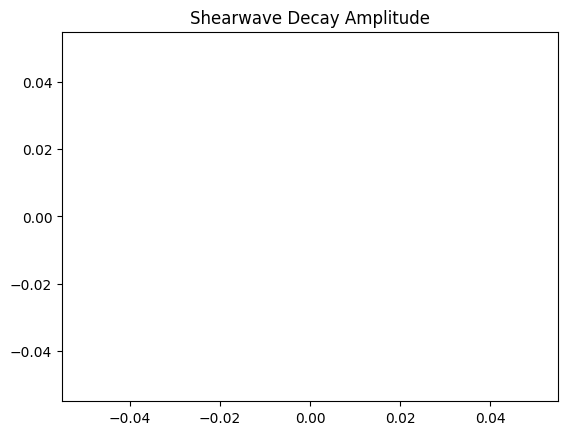

In [282]:
plt.plot(np.arange(len(amp)), amp)
plt.title("Shearwave Decay Amplitude")
plt.savefig("decay_plot.png")
plt.show()

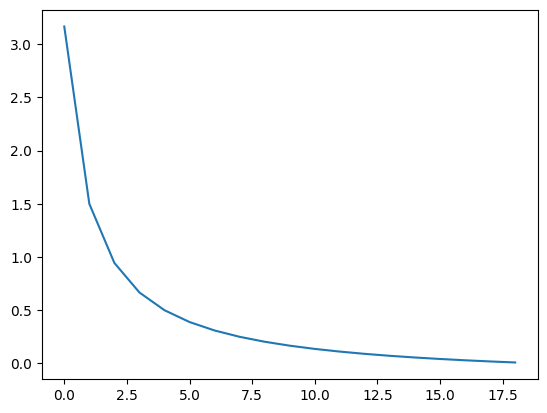

In [283]:
# Calculate analytic prediction of kinematic viscosity.
omega_values = [i / 100 for i in range(10, 200, 10)]
vis_ana = [1/3 * (1/omega - 1/2) for omega in omega_values]
plt.plot(vis_ana)